In [ ]:
# STEP 1: Install & Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')



In [ ]:
# STEP 2: Upload and Load Dataset
from google.colab import files
uploaded = files.upload()

# Replace the file name if different
df = pd.read_csv("dashboard_dataset_cleaned.csv")
df.head()


Saving dashboard_dataset_cleaned.csv to dashboard_dataset_cleaned (5).csv


,incident_date,country,city,incident_type,weapon_type,description,nkill,nwound,propvalue
0,NaN,Greece,Athens,bombing/explosion,Explosives,NaN,NaN,NaN,NaN
1,1970-01-02 00:00:00,United States,Oakland,bombing/explosion,Explosives,1/2/1970: Unknown perpetrators detonated explo...,0.0,0.0,22500.0
2,1970-01-01 00:00:00,United States,Baraboo,bombing/explosion,Explosives,NaN,0.0,0.0,0.0
3,1970-01-10 00:00:00,East Germany (GDR),Berlin,bombing/explosion,Explosives,NaN,NaN,NaN,NaN
4,1970-01-12 00:00:00,United States,New York City,bombing/explosion,Explosives,1/12/1970: Unknown perpetrators threw a pipe b...,0.0,0.0,NaN


In [ ]:
# STEP 3: Clean and Preprocess

df = df.dropna(subset=['incident_type', 'description', 'city'])

df[['nkill', 'nwound', 'propvalue']] = df[['nkill', 'nwound', 'propvalue']].fillna(0)

df['incident_type'] = df['incident_type'].apply(lambda x: 'chemical' if 'chemical' in x.lower() else 'fire_explosion')

label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['incident_type'])  # chemical=0, fire=1



In [ ]:
# STEP 4: Feature Engineering

# Text features from description
tfidf = TfidfVectorizer(max_features=500)
description_features = tfidf.fit_transform(df['description'])

# Encode city
df['city_encoded'] = LabelEncoder().fit_transform(df['city'])

# Final feature matrix (text + numeric)
features = np.hstack([
    description_features.toarray(),
    df[['nkill', 'nwound', 'propvalue', 'city_encoded']].values
])

labels = df['target']


In [ ]:
# STEP 5: Split Data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)



In [ ]:
# STEP 6: Train Models (Skipping NB on numeric data)

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    # "Naive Bayes": MultinomialNB()  # excluded from mixed data
}

results = {}

for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results[name] = acc
        print(f"\n{name}")
        print("Accuracy:", acc)
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    except ValueError as e:
        print(f"{name} failed: {e}")




Logistic Regression
Accuracy: 0.9947194719471947
                precision    recall  f1-score   support

      chemical       0.00      0.00      0.00        72
fire_explosion       0.99      1.00      1.00     13563

      accuracy                           0.99     13635
     macro avg       0.50      0.50      0.50     13635
  weighted avg       0.99      0.99      0.99     13635


Decision Tree
Accuracy: 0.9938393839383939
                precision    recall  f1-score   support

      chemical       0.43      0.53      0.47        72
fire_explosion       1.00      1.00      1.00     13563

      accuracy                           0.99     13635
     macro avg       0.71      0.76      0.74     13635
  weighted avg       0.99      0.99      0.99     13635


Random Forest
Accuracy: 0.9953061972863954
                precision    recall  f1-score   support

      chemical       1.00      0.11      0.20        72
fire_explosion       1.00      1.00      1.00     13563

      accuracy

In [ ]:
# STEP 7: Optional — Naive Bayes on Text Only
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(description_features, labels, test_size=0.2, random_state=42)

nb = MultinomialNB()
nb.fit(X_text_train, y_text_train)
y_pred_nb = nb.predict(X_text_test)

acc_nb = accuracy_score(y_text_test, y_pred_nb)
print("\nNaive Bayes (TF-IDF only)")
print("Accuracy:", acc_nb)
print(classification_report(y_text_test, y_pred_nb, target_names=label_encoder.classes_))

results["Naive Bayes (text only)"] = acc_nb




Naive Bayes (TF-IDF only)
Accuracy: 0.9534286762009534
                precision    recall  f1-score   support

      chemical       0.10      0.94      0.18        72
fire_explosion       1.00      0.95      0.98     13563

      accuracy                           0.95     13635
     macro avg       0.55      0.95      0.58     13635
  weighted avg       0.99      0.95      0.97     13635



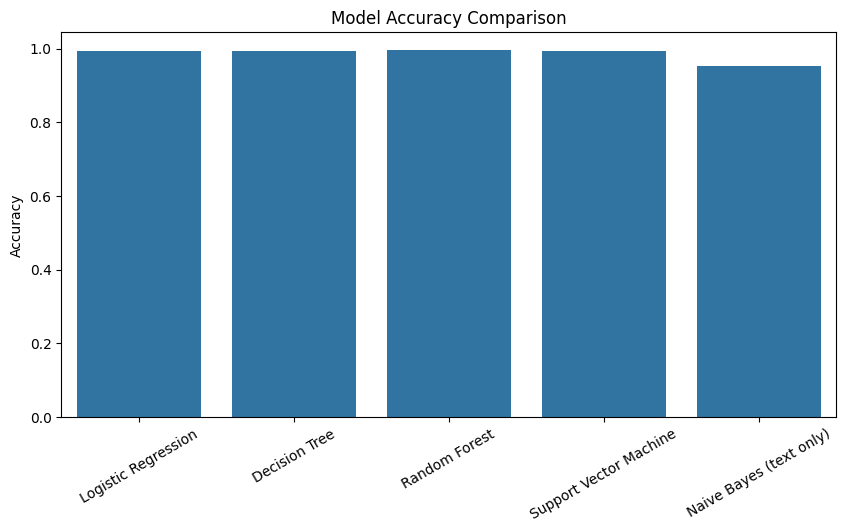

In [ ]:
# STEP 8: Plot Accuracy Comparison
plt.figure(figsize=(10,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()
